In [1]:
using PyPlot

## Problem setup

In [4]:
dX=0.06;
X=collect(-2:dX:2); 
Y=X[:];
Nx=size(X,1);
Ny=size(Y,1);
k=pi;
u0=[exp(1im*k*i*0-4*(i^2)-4*(j^2)) for i in X, j in Y];
ut0=complex(zeros(Ny,Nx));#-1im*k*[exp(1im*k*i-5*(i^2)+0*(j^2)) for i in X, j in Y];
vel=ones(size(ut0))+[0.05*cos(3*pi*(x))+0.05*cos(3*pi*(y)) for x in X, y in Y];
k*dX

0.18849555921538758

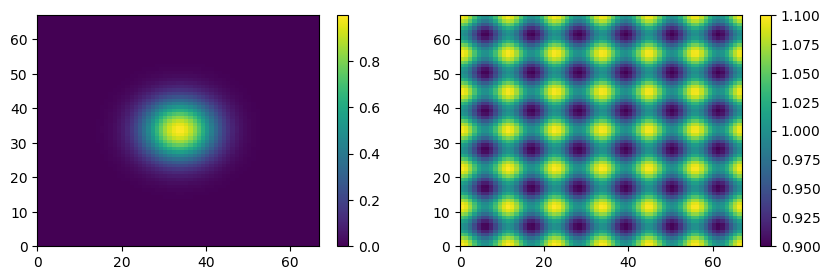

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000280F7B38>

In [5]:
figure(figsize=(10.0,3.0))
subplot(1,2,1);pcolormesh(real(u0))
colorbar()
subplot(1,2,2);pcolormesh(vel)
colorbar()

## Include solvers and interpolation functions

In [6]:
#include("wave_abc2.jl")
include("wave2.jl")

wave2 (generic function with 1 method)

In [7]:
function fourier2interp(a,m)
    Nrow=size(a,1);
    Ncol=size(a,2);
    aff =fft(a,[1,2]);
    
    interpmat=complex(zeros(m*(Nrow-1)+1,m*(Ncol-1)+1));
    intfrow_half=Int(floor(Nrow/2));
    intfcol_half=Int(floor(Ncol/2));
    
    interpmat[1:intfrow_half,1:intfcol_half]=aff[1:intfrow_half,1:intfcol_half];
    interpmat[1:intfrow_half,(m-1)*(Ncol-1)+intfcol_half+1:end]=aff[1:intfrow_half,intfcol_half+1:end];
    interpmat[(m-1)*(Nrow-1)+intfrow_half+1:end,1:intfcol_half]=aff[intfrow_half+1:end,1:intfcol_half];
    interpmat[(m-1)*(Nrow-1)+intfrow_half+1:end,(m-1)*(Ncol-1)+intfcol_half+1:end]=aff[intfrow_half+1:end,intfcol_half+1:end];
    
    return ifft(interpmat,[1,2])*((Nrow-1)*m+1)*((Ncol-1)*m+1)/(Nrow*Ncol);
end

function fourier2samp(a,m)
    Nrow=size(a,1);
    Ncol=size(a,2);
    aff =fft(a,[1,2]);
    
    samplemat=complex(zeros(Int(floor(Nrow/m))+1,Int(floor(Ncol/m))+1));
    
    intfrow_half=Int(floor(Nrow/(2*m)));
    intfcol_half=Int(floor(Ncol/(2*m)));
    
    samplemat[1:intfrow_half,1:intfcol_half] = aff[1:intfrow_half,1:intfcol_half];
    samplemat[1:intfrow_half,intfcol_half+1:end] = aff[1:intfrow_half,Ncol-intfcol_half:end];
    samplemat[intfrow_half+1:end,1:intfcol_half] = aff[Nrow-intfrow_half:end,1:intfcol_half];
    samplemat[intfrow_half+1:end,intfcol_half+1:end] = aff[Nrow-intfrow_half:end,Ncol-intfcol_half:end];
    
    return ifft(samplemat,[1,2])*((Nrow-1)/m+1)*((Ncol-1)/m+1)/(Nrow*Ncol);
end

fourier2samp (generic function with 1 method)

## Parareal function

In [8]:
function wave2dparareal(u0,ut0,vel,dX,pimax)
    t_final = 30;
    dT = 0.06;
    time = collect(0:dT:t_final);
    Nt = size(time,1);
    Nx = size(u0,2);
    Ny = size(u0,1);
    
    u  = complex(zeros(Ny,Nx,Nt));
    ut = complex(zeros(Ny,Nx,Nt));
    
    u[:,:,1]  = u0[:,:];
    ut[:,:,1] = ut0[:,:];
    
    m = 3;
    dx = dX/m;
    
    # initial parareal guess
    for i=2:Nt
        u[:,:,i],ut[:,:,i]=wave2(u[:,:,i-1],ut[:,:,i-1],vel,dX,dT);
    end
    
    # parareal iteration
    finesol = complex(zeros(Ny,Nx,Nt));
    finesolt = complex(zeros(Ny,Nx,Nt));
    coarsesol= complex(zeros(Ny,Nx,Nt));
    coarsesolt= complex(zeros(Ny,Nx,Nt));

    cfupdate=complex(zeros(Ny,Nx,Nt));
    cftupdate=complex(zeros(Ny,Nx,Nt));
    #g_ft=complex(zeros(Ny,Nx));
    #gt_ft=complex(zeros(Ny,Nx));
    cgft=complex(ones(Ny,Nx));  #zeros for phase-corrector
    cgtft=complex(ones(Ny,Nx));
    
    for pri=1:pimax
        
        # PARALLEL COMPUTATION
        for i=2:Nt
            u4f = fourier2interp(u[:,:,i-1],m);            
            ut4f = fourier2interp(ut[:,:,i-1],m);
            vel4f = fourier2interp(vel,m);
            u_fine,ut_fine = wave2(u4f,ut4f,vel4f,dx,dT);
            
            finesol[:,:,i]  = fourier2samp(u_fine,m);         
            finesolt[:,:,i]  = fourier2samp(ut_fine,m);   
            
            coarsesol[:,:,i],coarsesolt[:,:,i] = wave2(u[:,:,i-1],ut[:,:,i-1],vel,dX,dT);       
        end
        
        
        g_ft=complex(zeros(Ny,Nx));
        gt_ft=complex(zeros(Ny,Nx));       
        supportcgft=zeros(Ny,Nx);
        
        for i=2:Nt
            ffine = fft(finesol[:,:,i],[1,2]);
            ffinet= fft(finesolt[:,:,i],[1,2]);
            fcoarse=conj(cgft).*fft(coarsesol[:,:,i],[1,2]);
            fcoarset=conj(cgtft).*fft(coarsesolt[:,:,i],[1,2]);
            
            alpha=(angle.(conj(ffine).*fcoarse));
            betaa=(angle.(conj(ffinet).*fcoarset));
            g_ft=g_ft+(alpha-g_ft)/(i-1);
            gt_ft=gt_ft+(betaa-gt_ft)/(i-1); 
            
            supportcgft=supportcgft+
                    convert(Array{Int},((abs.(ffine)+abs.(ffinet))/maximum((abs.(ffine)+abs.(ffinet)))).>1e-3);
                
        end
        
        cgft=(exp.(im*g_ft).*cgft).*convert(Array{Int},abs.(supportcgft)/maximum(abs.(supportcgft)).>0.3);
        cgtft=(exp.(im*gt_ft).*cgtft).*convert(Array{Int},abs.(supportcgft)/maximum(abs.(supportcgft)).>0.3);
        
        # SERIAL UPDATE
        for i=2:Nt
            us,uts=wave2(u[:,:,i-1],ut[:,:,i-1],vel,dX,dT);
            
            ffine = fft(finesol[:,:,i],[1,2]);
            ffinet= fft(finesolt[:,:,i],[1,2]);
            fcoarse=conj(cgft).*fft(coarsesol[:,:,i]);
            fcoarset=conj(cgtft).*fft(coarsesolt[:,:,i]);
            fs=conj(cgft).*fft(us,[1,2]);
            fst=conj(cgtft).*fft(uts,[1,2]);
            
            cfupdate[:,:,i] = ffine-fcoarse;
            cftupdate[:,:,i]= ffinet-fcoarset;
            u[:,:,i] = ifft(fs+cfupdate[:,:,i],[1,2]);
            ut[:,:,i]= ifft(fst+cftupdate[:,:,i],[1,2]);
            
        end      
        
    end    
    
    return (u,ut,cgft,finesol,coarsesol)
    
end

wave2dparareal (generic function with 1 method)

## Test parareal function

In [9]:
u1,ut1=wave2dparareal(u0,ut0,vel,dX,0);

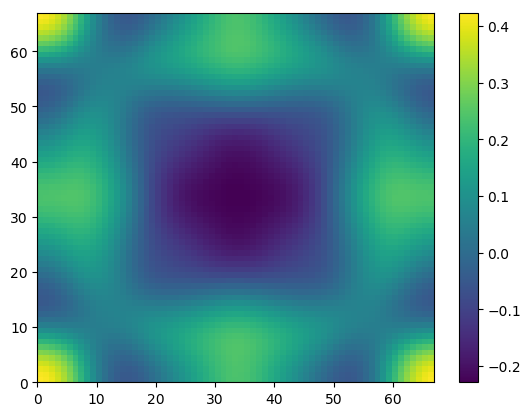

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000285BA9E8>

In [10]:
pcolormesh(real.(u1[:,:,end]))
colorbar()

### Compute full fine scale solution

In [11]:
m=3;
dx=dX/m;

u4f = fourier2interp(u0,m);
ut4f = fourier2interp(ut0,m);
velf = fourier2interp(vel,m);

ub,utb=wave2dparareal(u4f,ut4f,velf,dx,0);

ubdown = complex(zeros(Ny,Nx,size(ub,3)))
utbdown = complex(zeros(Ny,Nx,size(utb,3)))

for i=1:size(ub,3)   
    ubdown[:,:,i]  = fourier2samp(ub[:,:,i],m)
    utbdown[:,:,i]  = fourier2samp(utb[:,:,i],m)  
end

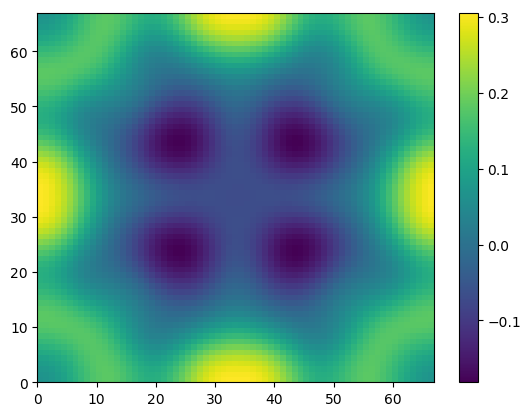

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000028962128>

In [12]:
pcolormesh(real.(ubdown[:,:,end]))
colorbar()

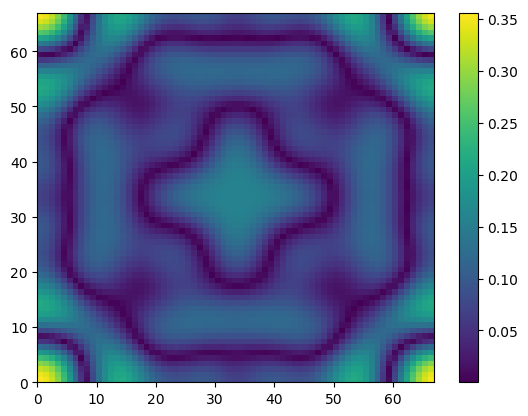

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000028CBA0F0>

In [13]:
pcolormesh(abs.(u1[:,:,end]-ubdown[:,:,end]))
colorbar()

## Tune parareal algo

In [14]:
u2,ut2=wave2dparareal(u0,ut0,vel,dX,2);
u3,ut3=wave2dparareal(u0,ut0,vel,dX,5);
u4,ut4=wave2dparareal(u0,ut0,vel,dX,10);

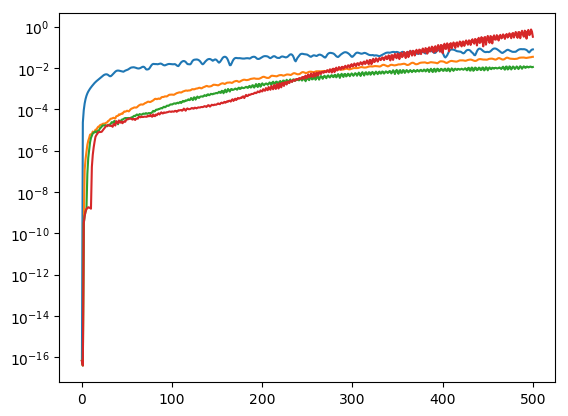

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000028DF3AC8>

In [15]:
meanerr1=[mean(abs.(u1[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u1,3))];
meanerr2=[mean(abs.(u2[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u2,3))];
meanerr3=[mean(abs.(u3[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u3,3))];
meanerr4=[mean(abs.(u4[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u4,3))];
semilogy(meanerr1)
semilogy(meanerr2)
semilogy(meanerr3)
semilogy(meanerr4)

In [ ]:
u2n,ut2n,gft2=wave2dparareal(u0,ut0,vel,dX,2);
u3n,ut3n,gft3=wave2dparareal(u0,ut0,vel,dX,5);
u4n,ut4n,gft4=wave2dparareal(u0,ut0,vel,dX,10);

In [ ]:
semilogy(meanerr1)
semilogy(meanerr2)
semilogy(meanerr3)
semilogy(meanerr4)
meanerr2n=[mean(abs.(u2n[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u2n,3))];
meanerr3n=[mean(abs.(u3n[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u3n,3))];
meanerr4n=[mean(abs.(u4n[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u4n,3))];
semilogy(meanerr2n,linestyle="--")
semilogy(meanerr3n,linestyle="--")
semilogy(meanerr4n,linestyle="--")
xlabel("time")
ylabel("mean error")

legend(["k=0","phase k=2","phase k=5","phase k=10","plain k=2","plain k=5","plain k=10"],loc="upper right",ncol=2)
ylim([1e-4,1e2])
#xlim([0,200])
#savefig("parareal2d_comparison_xlim20.png")